In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

2023-11-29 22:13:33.860447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 22:13:33.887278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 22:13:33.887844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 22:13:34.609993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# X data
path = '/home/dlopez/code/mtaha5/sign-language/notebook/X_train.csv'

# read CSV - DataFrame
X= pd.read_csv(path)

In [4]:
X.shape

(8700, 6912)

In [5]:
# y data
address = '/home/dlopez/code/mtaha5/sign-language/notebook/y_train.csv'

# read CSV - DataFrame
y= pd.read_csv(address)

In [6]:
y.shape

(8700, 1)

In [7]:
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,6902,6903,6904,6905,6906,6907,6908,6909,6910,6911
0,0.685210,0.014770,0.023291,0.444325,0.027411,0.031071,0.436677,0.021655,0.030905,0.437732,...,0.685290,0.879612,0.729585,0.690995,0.887842,0.741883,0.701961,0.866346,0.635832,0.591211
1,0.690155,0.013197,0.021567,0.443132,0.024143,0.028519,0.437327,0.018661,0.041588,0.440898,...,0.684854,0.880103,0.725606,0.690467,0.884687,0.744501,0.690887,0.873258,0.638792,0.591831
2,0.687720,0.014637,0.018793,0.445772,0.023129,0.023042,0.439266,0.016406,0.034163,0.443860,...,0.200391,0.267699,0.134936,0.192617,0.265540,0.133460,0.197817,0.399776,0.104606,0.187584
3,0.766307,0.128295,0.136470,0.612086,0.230861,0.268932,0.600572,0.226575,0.269947,0.586550,...,0.421511,0.611366,0.447340,0.463590,0.645852,0.469898,0.457279,0.730005,0.410333,0.396741
4,0.798752,0.129071,0.122843,0.654499,0.223050,0.214871,0.644005,0.225428,0.220565,0.634376,...,0.419310,0.518536,0.395444,0.415309,0.516727,0.397342,0.406318,0.611465,0.332004,0.345509


In [13]:
X[0:1].shape

(1, 6912)

In [18]:
#DataFrame to np array
X_array = X.values
X_reshaped= X_array.reshape((-1, 48, 48, 3))

In [21]:
X_reshaped[0:1].shape

(1, 48, 48, 3)

In [27]:
y['label'].unique()

array([ 9, 15,  6, 21, 11,  1,  3,  0, 16, 14, 20, 27,  8, 19,  2, 26, 10,
       17, 12,  5, 24, 28, 22,  4, 23, 13,  7, 18, 25])

In [30]:
# y Categorical
y_cat= tf.keras.utils.to_categorical(y, num_classes=29) 

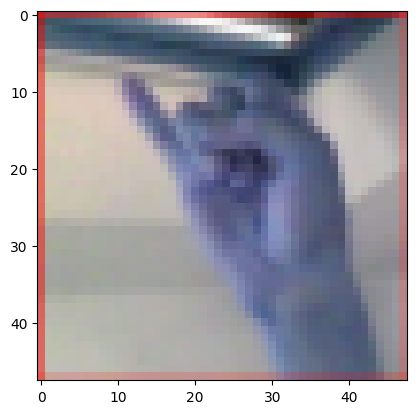

In [38]:
plt.imshow(X_reshaped[3]);

In [41]:
X_reshaped.shape

(8700, 48, 48, 3)

In [42]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_reshaped[0].shape)    
    return model

In [43]:
#architecture of the model using
model = load_model()
model.summary()

2023-11-29 22:18:31.628352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 22:18:31.628678: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [44]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    return model

In [136]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(250, activation='relu')
    # dense_layer1 = layers.Dense(100, activation='relu')
    prediction_layer = layers.Dense(29, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        # dense_layer1,
        prediction_layer
    ])
    return model

In [137]:
from tensorflow.keras import optimizers, models

def build_model():
    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [138]:
model_vgg16 = build_model()
model_vgg16.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 250)               128250    
                                                                 
 dense_21 (Dense)            (None, 29)                7279      
                                                                 
Total params: 14850217 (56.65 MB)
Trainable params: 135529 (529.41 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [139]:
#Split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_cat, test_size=0.2, random_state=42)

In [140]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6960, 48, 48, 3), (1740, 48, 48, 3), (6960, 29), (1740, 29))

In [141]:
#Split data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=23)

In [142]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4872, 48, 48, 3), (2088, 48, 48, 3), (4872, 29), (2088, 29))

In [143]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image data generator to training dataset and validation dataset
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    # brightness_range=[0.2,0.5],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    # brightness_range=[0.2,0.5],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [144]:
train_generator = train_datagen.flow( X_train, y_train, batch_size=64)

val_generator = val_datagen.flow( X_val, y_val, batch_size=64)


In [145]:
model_final = build_model()

es = EarlyStopping(patience = 10, restore_best_weights = True)

history = model_final.fit(train_generator,
                          steps_per_epoch=len(X_train) / 64,
                          validation_data=val_generator,
                          validation_steps=len(X_val) / 64,
                          epochs=100,
                          callbacks=[es],
                          verbose = 1)

Epoch 1/100
76/76 [==============================] - 17s 219ms/step - loss: 3.4360 - accuracy: 0.0404 - val_loss: 3.3654 - val_accuracy: 0.0522
Epoch 2/100
76/76 [==============================] - 18s 233ms/step - loss: 3.3243 - accuracy: 0.0768 - val_loss: 3.3138 - val_accuracy: 0.0843
Epoch 3/100
76/76 [==============================] - 20s 257ms/step - loss: 3.2762 - accuracy: 0.1028 - val_loss: 3.2574 - val_accuracy: 0.1121
Epoch 4/100
76/76 [==============================] - 20s 259ms/step - loss: 3.2341 - accuracy: 0.1211 - val_loss: 3.2101 - val_accuracy: 0.1169
Epoch 5/100
76/76 [==============================] - 20s 259ms/step - loss: 3.1830 - accuracy: 0.1468 - val_loss: 3.1681 - val_accuracy: 0.1360
Epoch 6/100
76/76 [==============================] - 20s 257ms/step - loss: 3.1491 - accuracy: 0.1433 - val_loss: 3.1264 - val_accuracy: 0.1470
Epoch 7/100
76/76 [==============================] - 20s 259ms/step - loss: 3.1027 - accuracy: 0.1583 - val_loss: 3.0906 - val_accuracy:

In [64]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

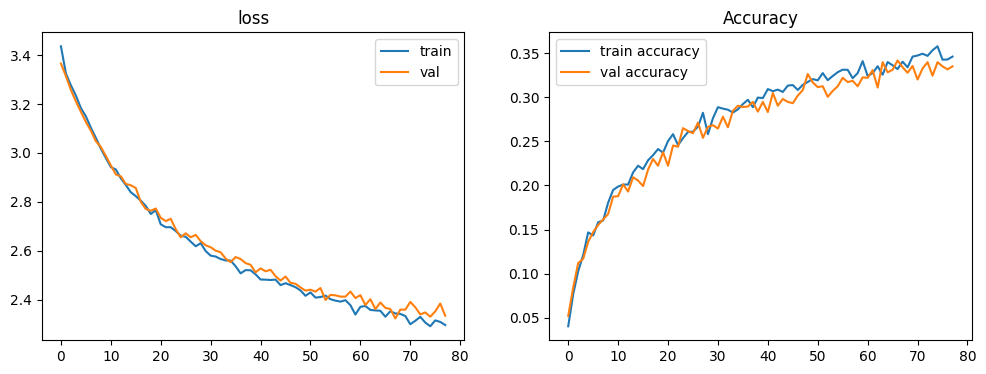

In [146]:
plot_history(history);

In [ ]:
#Save the model 
# model_final.save('model_120epoch.h5')
# model_final.save('model_120epoch.keras')

# Evaluate the model

In [147]:
#Evaluating the model

res_vgg = model_final.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]

55/55 [==============================] - 4s 73ms/step - loss: 2.0216 - accuracy: 0.4149


## Classification report & confusion matrix on multiclass

In [ ]:
df_test.label.value_counts().sort_index(ascending=True)

In [91]:
num_to_class = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N',
    14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U',
    21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing',
    28: 'space'
}

# num_to_class = {
#     0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
#     7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N',
#     14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U',
#     21: 'V', 22: 'W', 23: 'X', 24: 'Y'
# }

In [148]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test data
predictions = model_final.predict(X_test)

# Convert predictions to classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

confusion = confusion_matrix(true_classes, predicted_classes)

y_true=[num_to_class[y] for y in true_classes]
y_pred=[num_to_class[y] for y in predicted_classes]

55/55 [==============================] - 4s 73ms/step


In [149]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

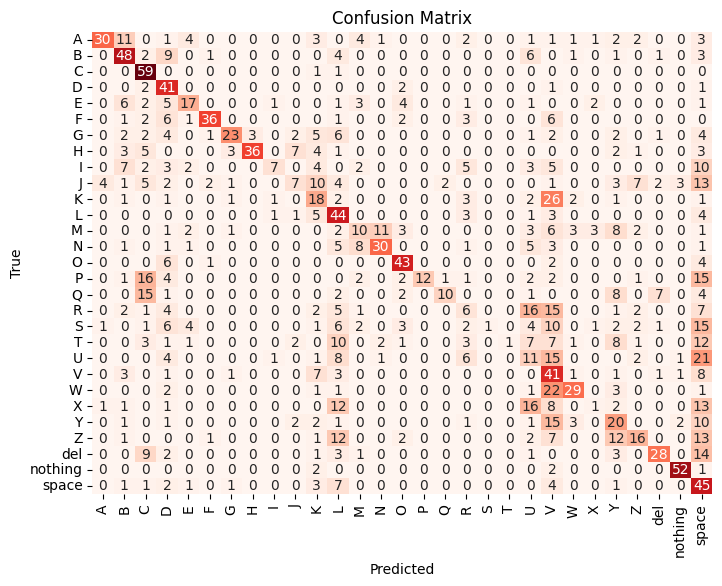

In [150]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False,
           xticklabels=np.unique(y_true),
           yticklabels=np.unique(y_pred))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [151]:
print(classification_report(true_classes, predicted_classes, target_names=list(num_to_class.values())))

              precision    recall  f1-score   support

           A       0.83      0.45      0.58        67
           B       0.53      0.63      0.57        76
           C       0.46      0.97      0.63        61
           D       0.38      0.87      0.53        47
           E       0.52      0.39      0.44        44
           F       0.86      0.62      0.72        58
           G       0.74      0.40      0.52        58
           H       0.92      0.55      0.69        65
           I       0.64      0.14      0.23        50
           J       0.33      0.10      0.16        67
           K       0.25      0.31      0.28        59
           L       0.31      0.71      0.43        62
           M       0.30      0.18      0.22        56
           N       0.67      0.54      0.59        56
           O       0.67      0.77      0.72        56
           P       1.00      0.20      0.34        59
           Q       0.77      0.20      0.32        50
           R       0.16    

# Import an image

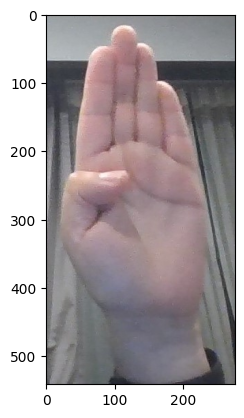

In [279]:
from PIL import Image

# Load the image
#image_path = '/home/dlopez/code/mtaha5/sign-language/raw_data/asl_alphabet_train/A/A1161.jpg'  
image_path = '/home/dlopez/code/mtaha5/sign-language/raw_data/Letters/B.jpg'
img = Image.open(image_path)

# show the image
plt.imshow(img)
plt.axis('on') 
plt.show()

In [280]:
np.array(img).shape

(542, 277, 3)

In [290]:
#Function to resize image maintain aspect ratio

from PIL import Image
import numpy as np

def resize(image_pil, width, height):
    # Calculate aspect ratio
    ratio = min(width / image_pil.width, height / image_pil.height)
    new_size = (round(image_pil.width * ratio), round(image_pil.height * ratio))
    
    # Resize the image while preserving aspect ratio
    image_resized = image_pil.resize(new_size, Image.LANCZOS)

    # Create a blank background
    background = Image.new('RGB', (width, height), (255, 255, 255))  # You can adjust the background color
    
    # Calculate the position to paste the resized image in the center
    paste_location = ((width - new_size[0]) // 2, (height - new_size[1]) // 2)
    
    # Paste the resized image onto the background
    background.paste(image_resized, paste_location)

    return background

In [291]:
#Apply the function 

new_width = 48      # Define the desired dimensions
new_height = 48

resized_with_background = resize(img, new_width, new_height)   # Resize and add background


In [292]:
# Convert the image to an array using NumPy and normalize
img_array = np.array(resized_with_background) / 255

In [293]:
img_array.shape

(48, 48, 3)

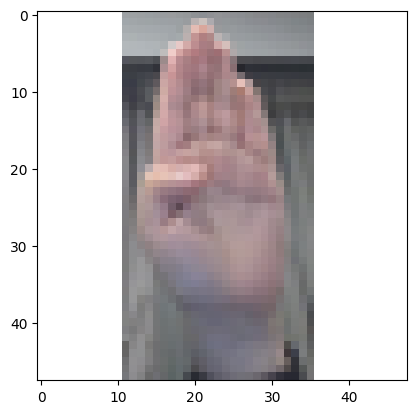

In [294]:
plt.imshow(img_array);

In [295]:
img_array_expanded = np.expand_dims(img_array, axis=0)

In [296]:
img_array_expanded.shape

(1, 48, 48, 3)

## Prediction

In [297]:
letter={
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N',
    14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U',
    21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing',
    28: 'space'
}

predict = model_final.predict(img_array_expanded)
predict

1/1 [==============================] - 0s 25ms/step


array([[1.8182587e-02, 1.8290058e-01, 1.9500660e-03, 9.6063964e-02,
        1.5409860e-01, 5.6614425e-02, 4.3752678e-03, 4.2056257e-04,
        1.0508315e-01, 7.9362551e-03, 1.2821757e-02, 6.1502729e-02,
        4.4121124e-02, 1.7736556e-02, 1.4145037e-02, 9.7016674e-03,
        1.0770807e-03, 1.9218899e-02, 3.3902325e-02, 1.3606872e-02,
        3.6073469e-02, 1.7866224e-02, 8.9386208e-03, 1.6249510e-02,
        2.5515540e-02, 2.2595761e-02, 1.8226370e-03, 1.7141990e-04,
        1.5307218e-02]], dtype=float32)

In [298]:
predicted_class_index = np.argmax(predict)
letter_predicted=letter[predicted_class_index]
predicted_class_index, letter_predicted

(1, 'B')

TypeError: Invalid shape (6912,) for image data

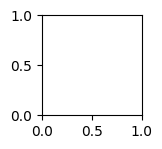

In [107]:
images = df_test.iloc[:, 1:].values  
labels = df_test['label'].values
num_images_per_label = 1 
num_columns = 5
num_rows = len(np.unique(labels)) 

plt.figure(figsize=(15, 45))

for label in range(len(np.unique(labels))):
    label_images = images[labels == label][:num_images_per_label]

    for i, img in enumerate(label_images, 1):
        plt.subplot(num_rows, num_columns, (label * num_images_per_label) + i)
        img = img.reshape(28, 28)  # Tamaño de la imagen: 28x28
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()